In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

%matplotlib inline

In [2]:
# Initializing Variables
subjects = 1       # Number of subjects data is collected for
sequences = 1      # Number of sequences per subject

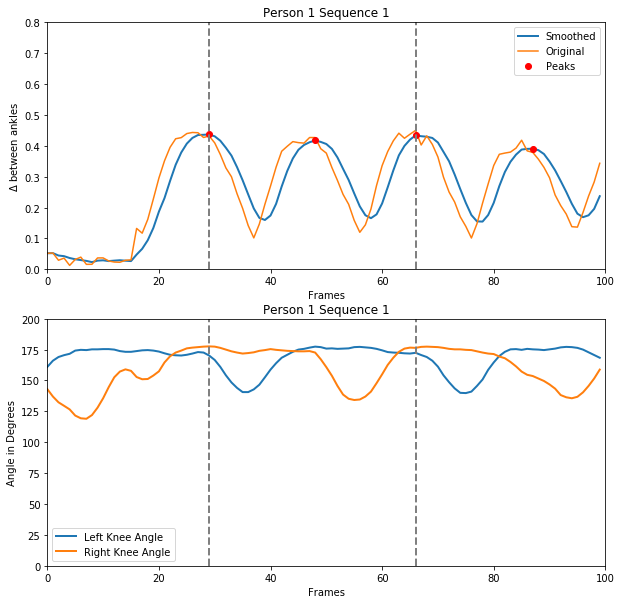

In [3]:
# Outer loop for number of people
for sub_num in range(1, subjects+1):
    # Inner loop for number of runs per person
    for run_num in range(1, sequences+1):
        
        # loading the JRD data
        subsec1 = 'Subject_%d_Seq_%d_GaitCycle_N.csv' % (sub_num, run_num)

        # Reading the JRD data
        sequence = pd.read_csv(subsec1, header=0, index_col=False)

        # Smoothing the data  
        GaitCycleData = sequence.rolling(window=5, min_periods=1).mean()

        plt.figure(figsize=(10,10))
        
        plt.subplot(2, 1, 1)
        plt.plot(GaitCycleData, lw=2)
        plt.plot(sequence)
        # Creating the axis
        plt.xlim([0, 100])
        plt.ylim([0, 0.8])

        # Creating Y axis label
        plt.ylabel('$\Delta$ between ankles')
        plt.xlabel('Frames')  
        # Creating the title for the graph
        plt.title('Person %d Sequence %d' % (sub_num, run_num))

        # Initializing variables for the next part (first frame)
        FrameStart = 1
        # Initializing variables for the next part (last frame)
        FrameEnd,_ = GaitCycleData.shape

        # Finding the peaks to be used for finding gait cycle 
        # In this part, we find and store all the valid peaks
        # A 'valid' peak is a peak that has:
        # A minimum prominence of:  0.13
        # A minimum width of:       7.4 frames
        # A maximum width of:       18 frames

        sub_GaitCycleData = GaitCycleData.to_numpy().reshape((-1,))
        [loc, prop] = find_peaks(sub_GaitCycleData, prominence=0.13, width=(7.4, 18))

        plt.plot(loc, sub_GaitCycleData[loc], 'ro')
        plt.legend(['Smoothed', 'Original', 'Peaks'])
        
        # Checking to see if gait cycle is valid
        # For the JRD method to work, we need to find 3 valid peaks
        # This 'if' statement checks to see if there are 3 valid peaks
        if (len(loc) < 3):
           print('Invalid Data for person %d sequence %d' % (sub_num, run_num))
        else:
            # If valid, the start of the gait cycle begins at the location of peak 1
            FrameStart = loc[0]
            # If valid, the end of the gait cycle happens at the location of peak 3
            FrameEnd = loc[2]

            # Adding lines to represent where gait cycle starts and stops 
            plt.axvline(x=FrameStart, color='grey', linestyle='--', lw=2)
            plt.axvline(x=FrameEnd, color='grey', linestyle='--', lw=2)

        # KneeAngles
        # Here we will plot the knee angles and overlay the gait cycle found earlier

        # loading the JRA data
        subsec2 = 'Subject_%d_Seq_%d_JointAngles_N.csv' % (sub_num, run_num)
        # Reading the JRA data
        sequence = pd.read_csv(subsec2, header=0, index_col=False)

        # Reading the JRA data
        AngleData = sequence.iloc[:,[0,1]]

        # Reading the JRA data for Left/Right Knee
        AngleDataL = AngleData.iloc[:,0]
        AngleDataR = AngleData.iloc[:,1]

        # Smoothing the JRA data for Left/Right Knee
        AngleDataL = AngleDataL.rolling(window=5, min_periods=1).mean()
        AngleDataR = AngleDataR.rolling(window=5, min_periods=1).mean()

        plt.subplot(2, 1, 2)
        plt.plot(AngleDataL, lw=2)
        plt.plot(AngleDataR, lw=2)

        # Adding lines to represent where gait cycle starts and stops on the Angle graph
        plt.axvline(x=FrameStart, color='grey', linestyle='--', lw=2)
        plt.axvline(x=FrameEnd, color='grey', linestyle='--', lw=2)

        # Creating the axis
        plt.xlim([0, 100])
        plt.ylim([0, 200])

        plt.ylabel('Angle in Degrees')
        plt.xlabel('Frames')  
        plt.legend(['Left Knee Angle', 'Right Knee Angle'])
        # Creating the title for the graph
        plt.title('Person %d Sequence %d' % (sub_num, run_num))
        plt.show()

In [4]:
# ------------------------------ to find min Left and Right Knee Angles
#angledegR = transpose(angledegR);
    
AngleDataR = AngleDataR.rolling(window=5, min_periods=1).mean()
AngleDataL = AngleDataL.rolling(window=5, min_periods=1).mean()


angledegR_T = AngleDataR[FrameStart:FrameEnd]
angledegL_T = AngleDataL[FrameStart:FrameEnd]

# Finding lowest point in the gait cycle
MinangledegR = min(angledegR_T)
MinangledegL = min(angledegL_T)

print(MinangledegR, MinangledegL)

# -------------------------------
#angledegR = transpose(angledegR);
#angledegR = smooth(angledegR);

#angledegR_T = angledegR(FrameStart:FrameEnd);
#angledegL_T = angledegL(FrameStart:FrameEnd);

# Finding lowest point in the gait cycle
#MinangledegR = min(angledegR_T);
#MinangledegL = min(angledegL_T);

135.9200000000001 142.92


# Classification

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

### Loading Data

In [6]:
data = pd.read_csv('Combined_TData.csv', header=0, index_col=False)
data.head()

,Person,Sequence,Min_R_Knee_Angle,Min_L_Knee_Angle,Status
0,1,1,147.443034,141.046628,No Limp
1,1,2,140.965314,136.279629,No Limp
2,1,3,138.509256,140.469984,No Limp
3,1,4,141.459422,140.050408,No Limp
4,1,5,141.455659,123.087109,No Limp


In [7]:
X = data[['Min_R_Knee_Angle', 'Min_L_Knee_Angle']]
y = data['Status']

print('Original classes: ', y.unique())

# encoding y classes
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)
print('Encoded classes: ', set(y))

Original classes:  ['No Limp' 'Left' 'Right']
Encoded classes:  {0, 1, 2}


### Linear Discriminant Analysis

In [8]:
clf_lda = LinearDiscriminantAnalysis(solver='svd')

scores_lda = cross_val_score(clf_lda, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lda.mean(), scores_lda.std() * 2))

y_pred_lda = clf_lda.fit(X, y).predict(X)
tp_lda = (y == y_pred_lda) # True Positive

Accuracy: 0.90 (+/- 0.14)


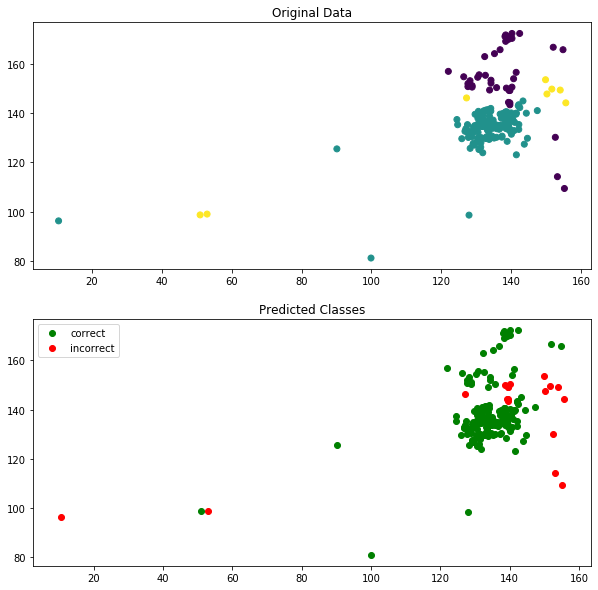

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y)
plt.title('Original Data')
plt.subplot(2,1,2)
plt.scatter(X.iloc[tp_lda==1,0], X.iloc[tp_lda==1,1], c='g')
plt.title('Predicted Classes')
plt.scatter(X.iloc[tp_lda==0,0], X.iloc[tp_lda==0,1], c='r')
plt.legend(['correct', 'incorrect'])

### Support Vector Machines

In [10]:
clf_svm = SVC(kernel="linear")
    
scores_svm = cross_val_score(clf_svm, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

y_pred_svm = clf_svm.fit(X, y).predict(X)
tp_svm = (y == y_pred_svm) # True Positive

Accuracy: 0.91 (+/- 0.08)


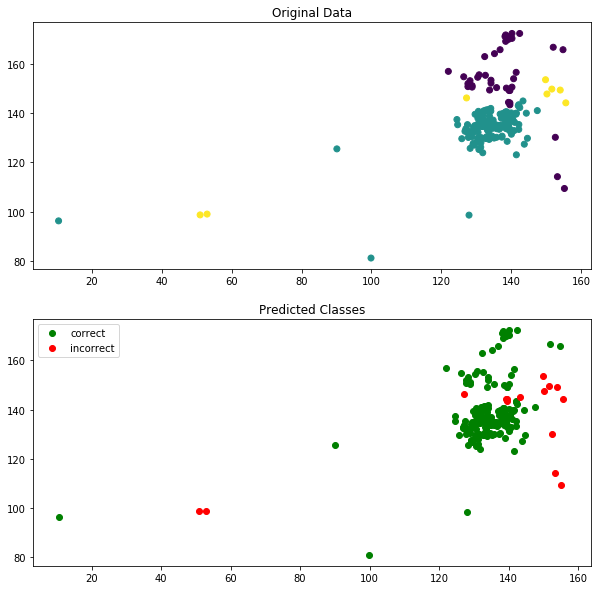

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y)
plt.title('Original Data')
plt.subplot(2,1,2)
plt.scatter(X.iloc[tp_svm==1,0], X.iloc[tp_svm==1,1], c='g')
plt.scatter(X.iloc[tp_svm==0,0], X.iloc[tp_svm==0,1], c='r')
plt.title('Predicted Classes')
plt.legend(['correct', 'incorrect'])

### K-Nearest Neighbors

In [12]:
clf_knn = KNeighborsClassifier(n_neighbors=1)
    
scores_knn = cross_val_score(clf_knn, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

y_pred_knn = clf_knn.fit(X, y).predict(X)
tp_knn = (y == y_pred_knn) # True Positive

Accuracy: 0.97 (+/- 0.10)


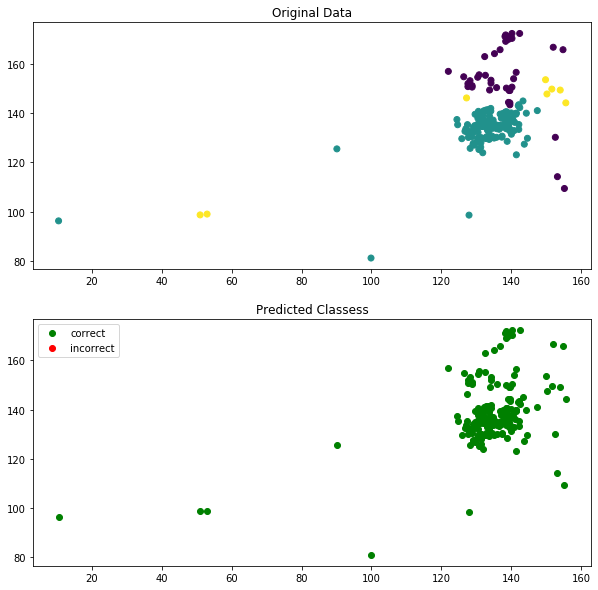

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y)
plt.title('Original Data')
plt.subplot(2,1,2)
plt.scatter(X.iloc[tp_knn==1,0], X.iloc[tp_knn==1,1], c='g')
plt.title('Predicted Classess')
plt.scatter(X.iloc[tp_knn==0,0], X.iloc[tp_knn==0,1], c='r')
plt.legend(['correct', 'incorrect'])